In [1]:
import numpy as np

from commons import *
from dataset_loader import load_images, prepare_dataset
from IPython.display import display
import matplotlib.pyplot as plt
import cv2
import pickle
from keras.models import load_model


DOTS_SRC = 'hit-images-final2/dot'
TRACKS_SRC = 'hit-images-final2/line'
WORMS_SRC = 'hit-images-final2/worms'
ARTIFACTS_SRC = 'hit-images-final2/artefact'

DOTS_AC = 'cache/dots_100000.h5'
TRACKS_AC = 'cache/tracks_100000.h5'
WORMS_AC = 'cache/worms_100000.h5'
ARTIFACTS_AC = 'cache/artifacts_100000.h5'



dots_set =  prepare_dataset(load_images(DOTS_SRC))
worms_set =  prepare_dataset(load_images(WORMS_SRC))
tracks_set =  prepare_dataset(load_images(TRACKS_SRC))
artifacts_set =  prepare_dataset(load_images(ARTIFACTS_SRC))

dots_autoencoder = load_model(DOTS_AC)
worms_autoencoder = load_model(WORMS_AC)
tracks_autoencoder = load_model(TRACKS_AC)
artifacts_autoencoder = load_model(ARTIFACTS_AC)

on_dots = calc_similarity(dots_autoencoder, dots_set, tracks_set, worms_set, artifacts_set)
on_worms = calc_similarity(worms_autoencoder, dots_set, tracks_set, worms_set, artifacts_set)
on_tracks = calc_similarity(tracks_autoencoder, dots_set, tracks_set, worms_set, artifacts_set)
on_artifacts = calc_similarity(artifacts_autoencoder, dots_set, tracks_set, worms_set, artifacts_set)

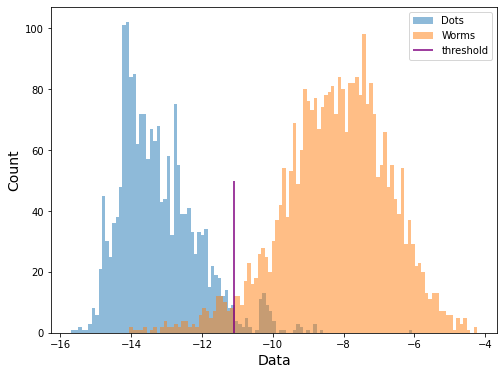

Threshold value: -11.091067446192564
False classified rate %: 4.008097165991903


In [4]:
def append_label_column(v, c):
    with_c = np.vstack([v, np.ones(v.shape) * c])
    transposed = with_c.transpose()
    return transposed

dots = on_dots['dots']
tracks = on_dots['tracks']

def find_threshold(a, b):
    a = sorted(a)
    b = sorted(b)

    ca = a[len(a) // 2]
    cb = b[len(b) // 2]

    if ca > cb:
        swap = a
        a = b
        b = swap

    np_a = np.array(a)
    np_b = np.array(b)

    np_a_ex = append_label_column(np_a, 1)
    np_b_ex = append_label_column(np_b, 2)

    left = 4
    right = 3

    np_ab = np.vstack([np_a_ex, np_b_ex])
    np_ab = np_ab[np_ab[:, 0].argsort()]

    labels = np_ab[:,1]

    cumsum_a = np.where(labels == 1, 1 / len(a), 0).cumsum()
    cumsum_ar = np.flip(np.flip(np.where(labels == 1, 1 / len(a), 0)).cumsum())
    cumsum_b = np.where(labels == 2, 1 / len(b), 0).cumsum()
    cumsum_br = np.flip(np.flip(np.where(labels == 2, 1 / len(b), 0)).cumsum())

    np_ab_ex = np.hstack([np_ab, np.vstack([cumsum_a, cumsum_ar, cumsum_b, cumsum_br]).transpose()])

    half = 0
    for row in np_ab_ex:
        rl = row[left]
        rr = row[right]
        if rl > rr:
            break
        half += 1

    threshold = (np_ab_ex[half - 1, 0] + np_ab_ex[half, 0])/2

    fp_a = np_ab[np.where((np_ab[:,1] == 1) & (np_ab[:,0] >= threshold))]
    fp_b = np_ab[np.where((np_ab[:,1] == 2) & (np_ab[:,0] <= threshold))]

    percent = (fp_a.shape[0] + fp_b.shape[0]) / np_ab.shape[0] * 100

    return threshold, percent


def plot_threshold(a, b, threshold, name_a, name_b):
    plt.figure(figsize=(8,6))
    plt.hist(a, bins=100, alpha=0.5, label=name_a)
    plt.hist(b, bins=100, alpha=0.5, label=name_b)
    plt.vlines(x = threshold, ymin = 0, ymax = 50, colors = 'purple', label = 'Threshold')
    plt.xlabel("Data", size=14)
    plt.ylabel("Count", size=14)
    plt.legend(loc='upper right')
    plt.show()


threshold, percent = find_threshold(dots, tracks)
plot_threshold(dots, tracks, threshold, 'Dots', 'Worms')

print('Threshold value: ' + str(threshold))
print('False classified rate %: ' + str(percent))